# Painter By Numbers- Final Deep Learning Project


By Shira Tzadok and Shahar Tavor


### Goals:
Classifying two images of paintings, as belonging to the same artist or not. Note that,
artist in the test set should be different from the artists in the training set.
Data: https://www.kaggle.com/c/painter-by-numbers.
Approach: Convolutional Siamese Network


### Download The Datasets

In [ ]:
import itertools
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
warnings.filterwarnings("ignore")
# Use .to(device) when needed to train on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import shutil
%matplotlib inline 
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
import torchvision.models as models
import torch.nn.init as init

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [ ]:
# Suggesed uploading script
! pip install -q kaggle
from google.colab import files 
files.upload() # Upload kaggle.json as described in the link
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mfekadu/painters-train-part-1    
! kaggle datasets download mfekadu/painters-train-part-2
! kaggle datasets download mfekadu/painters-train-part-3 
! kaggle datasets download mfekadu/painter-test 

Saving kaggle.json to kaggle.json
100% 12.4G/12.4G [01:42<00:00, 113MB/s]
100% 12.4G/12.4G [01:42<00:00, 130MB/s]
100% 11.6G/11.6G [01:36<00:00, 166MB/s]
100% 11.6G/11.6G [01:36<00:00, 129MB/s]
100% 12.1G/12.2G [01:45<00:00, 132MB/s]
100% 12.2G/12.2G [01:45<00:00, 124MB/s]
100% 11.1G/11.1G [01:23<00:00, 122MB/s]
100% 11.1G/11.1G [01:23<00:00, 143MB/s]


In [ ]:
! unzip -q painters-train-part-1.zip -d data
! unzip -qo painters-train-part-2.zip -d data
! unzip -qo painters-train-part-3.zip -d data
! unzip -qo painter-test.zip -d data


In [ ]:
#move all images from all 9 train folders and test folder to the same folder
%mkdir all_data
%mkdir artists
for i in range(1,10):
  folder_name ="data/train_{0}/train_{0}/*".format(str(i))
  %mv $folder_name all_data/
%mv data/test/test/* all_data/

### Viewing The Datasets




Remove corrupted images:

In [ ]:
df = pd.read_csv("data/" + 'all_data_info.csv')
print("df.shape", df.shape)
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
#remove corrupted
df = df[df["new_filename"].isin(list_of_corrupted) == False]
print("df.shape", df.shape)

df.shape (103250, 12)
df.shape (103240, 12)


List of classes (artists):

In [ ]:
files_df = df[['artist', 'new_filename']] 
artists = {}
for artist in files_df['artist']:
  if artist not in artists.keys():
    artists.update({artist:1})
  else:
      artists[artist]+=1

print("number of artist",len(artists))
indexs_to_artists = dict(zip(range(len(artists)),artists.keys()))
artists_to_indexs = dict(zip(artists.keys(),range(len(artists))))

print(indexs_to_artists)
print(artists_to_indexs)

for index in range(0,len(artists)):
  new_dir = "artists/{0}".format(str(index))
  os.makedirs(new_dir)

Divide pictures to folders:

In [ ]:
#divide pictures to folders
for index, row in files_df.iterrows():
    file_name = "all_data/"+row['new_filename']
    if os.path.exists(file_name):
        class_to_move = "artists/{0}".format(artists_to_indexs[row['artist']])
        shutil.move(file_name, class_to_move)


Create dataloader, divide dataset to train,validation and test. \
The test images have different artists.

In [ ]:
artists_train = range(0,1800) #8500 
artists_test= range(1800,2319) #500
os.makedirs("test")
for index in artists_train:
      folder_name ="artists/{0}/".format(str(index))
      shutil.move(folder_name,"train/")
for index in artists_test:
      folder_name ="artists/{0}/".format(str(index))
      shutil.move(folder_name,"test/")

### Custom Dataloaders

Triplet loss custom dataset function

In [ ]:
class SiameseNetworkDatasetTriple(Dataset):
    def __init__(self,imageFolderDataset,transform):
        self.imageFolderDataset = imageFolderDataset.imgs #path to images folder
        self.transform = transform

    #get tuple of 5: img1,class1,img2,class2,label(1- same artists 0-different)
    def __getitem__(self,index):
      anchor_path = self.load_image_path(index)
      class_anchor = self.get_class_img(anchor_path)
      postive_path_choice ='/'.join(anchor_path.split("/")[:-1])
      img_list = os.listdir(postive_path_choice)
      positive_path= rnd.choice(img_list)
      positive_path = os.path.join(postive_path_choice, positive_path)

      negative_path = ""
      while True:
        #keep looping till a different class image is found
        negative_path= rnd.choice(self.imageFolderDataset)[0]
        class_negative = self.get_class_img(negative_path)
        if class_anchor!=class_negative:
            break
       
      img_a =  transform(Image.open(anchor_path).convert('RGB'))
      img_p = transform(Image.open(positive_path).convert('RGB'))
      img_n= transform(Image.open(negative_path).convert('RGB'))
      return img_a,class_anchor,img_p ,img_n ,class_negative

    #paths are: /content/train/619/99268.jpg [-2] is 619
    def get_class_img(self,path):
      return int(path.split("/")[-2])
    

    def __len__(self):
        return len(self.imageFolderDataset)

    def load_image_path(self, index):
        image_path = self.imageFolderDataset[index][0]
        return image_path


Custom dataset function for 2 samples: \\
Returns 2 images and a label - 0 is the same artist, 1 otherwise

In [ ]:
class SiameseNetworkDatasetTwo(Dataset):
    
    def __init__(self,imageFolderDataset,transform):
        self.imageFolderDataset = imageFolderDataset.imgs #path to images folder
        self.transform = transform

    #get tuple of 5: img1,class1,img2,class2,label(1- same artists 0-different)
    def __getitem__(self,index):
        img0_path = self.load_image_path(index)
        class_img0 = self.get_class_img(img0_path)
        img1_path = ""
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = rnd.randint(0,1) 

        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_path= rnd.choice(self.imageFolderDataset)[0]
                class_img1 = self.get_class_img(img1_path)
                if class_img0==class_img1:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_path= rnd.choice(self.imageFolderDataset)[0]
                class_img1 = self.get_class_img(img1_path)
                if class_img0!=class_img1:
                    break
       
        img0 =  transform(Image.open(img0_path).convert('RGB'))
        img1 = transform(Image.open(img1_path).convert('RGB'))
        return img0,class_img0, img1 ,class_img1, int(class_img0!=class_img1)

    #paths are: /content/train/619/99268.jpg [-2] is 619
    def get_class_img(self,path):
      return int(path.split("/")[-2])

    def __len__(self):
        return len(self.imageFolderDataset)

    def load_image_path(self, index):
        image_path = self.imageFolderDataset[index][0]
        return image_path


Using the custom dataset with Pytorch dataloader

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor() 
])

prec = 0.5
batch_size= 64

dataset_all = ImageFolder("train", transform=transform)
print(len(dataset_all))
all_ds = SiameseNetworkDatasetTriple(dataset_all, transform=transform)

train_ds, vali_ds= random_split(all_ds, (int(0.8*len(all_ds)),len(all_ds)-int(0.8*len(all_ds))))

train_ds_small, train_ds_big= random_split(train_ds, (int(prec*len(train_ds)),len(train_ds)-int(prec*len(train_ds))))
vali_ds_small, vali_ds_big= random_split(vali_ds, (int(prec*len(vali_ds)),len(vali_ds)-int(prec*len(vali_ds))))


train_dl = DataLoader(train_ds_small, batch_size=batch_size,shuffle = True,num_workers=3, drop_last = True)
vali_dl = DataLoader(vali_ds_small, batch_size=batch_size, num_workers=3, shuffle = True, drop_last = True)


dataset_test = ImageFolder("test", transform=transform)
test_ds = SiameseNetworkDatasetTwo(dataset_test, transform=transform)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=3, drop_last = True)

print("len train: ",len(train_dl.dataset))
print("len vali: ",len(vali_dl.dataset))
print("len test: ",len(test_dl.dataset))


98468
len train:  39387
len vali:  9847
len test:  4725


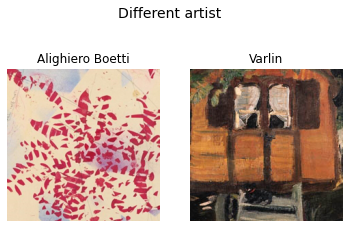

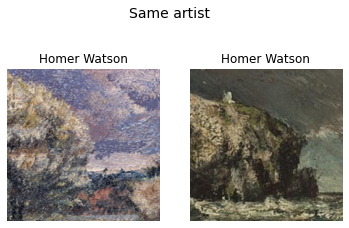

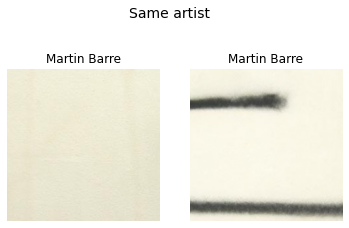

In [ ]:
def show_images_two():
  num_of_images = 3
  ds=test_dl.dataset
  index_fig = 1
  labels = {0:"Same artist",1:"Different artist"}
  for i in range(num_of_images):
    rand_img = ds[rnd.randint(0, len(ds))]
    image1,class1,image2,class2,label= rand_img[0], rand_img[1], rand_img[2],rand_img[3], rand_img[4]
    npimg1=np.transpose(image1.numpy(), (1, 2, 0)) #from BRG to RGB
    npimg2=np.transpose(image2.numpy(), (1, 2, 0)) #from BRG to RGB
    fig_sub, ax = plt.subplots(1, 2)
    ax[0].imshow(npimg1) 
    ax[0].axis("off")
    ax[0].set_title(indexs_to_artists[class1])
    ax[1].imshow(npimg2) 
    ax[1].axis("off")
    ax[1].set_title(indexs_to_artists[class2])
    fig_sub.suptitle(labels[label], fontsize=14)
   
show_images_two()

### Display 3 Random Triplets From Test

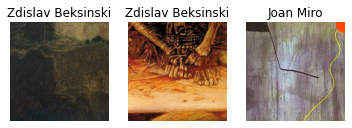

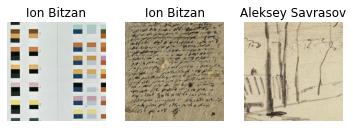

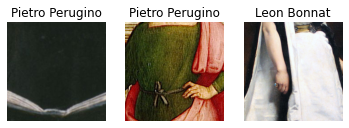

In [ ]:
# Triple
def show_images():
  num_of_images = 3
  ds=train_dl.dataset
  index_fig = 1
  labels = {1:"Same artist",0:"Different artist"}
  for i in range(num_of_images):
    rand_img = ds[rnd.randint(0, len(ds))]
    img_a,class_anchor,img_p ,img_n ,class_negative= rand_img[0], rand_img[1], rand_img[2],rand_img[3], rand_img[4]
    npimga=np.transpose(img_a.numpy(), (1, 2, 0)) #from BRG to RGB
    npimgp=np.transpose(img_p.numpy(), (1, 2, 0)) #from BRG to RGB
    npimgn=np.transpose(img_n.numpy(), (1, 2, 0)) #from BRG to RGB
    fig_sub, ax = plt.subplots(1, 3)
    ax[0].imshow(npimga) 
    ax[0].axis("off")
    ax[0].set_title(indexs_to_artists[class_anchor])
    ax[1].imshow(npimgp) 
    ax[1].axis("off")
    ax[1].set_title(indexs_to_artists[class_anchor])
    ax[2].imshow(npimgn) 
    ax[2].axis("off")
    ax[2].set_title(indexs_to_artists[class_negative])
    fig_sub.suptitle("", fontsize=14)
   
show_images()

### Convolutional Siamese Network Architecture

In [ ]:
class SiameseNet_Resnet18_Triple(nn.Module):
    def __init__ (self):
      super().__init__()
      self.resnet = models.resnet18(pretrained=True)
      
    def forward(self, input1, input2, input3):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        anchor_output  = self.resnet(input1)
        positive_output = self.resnet(input2)
        negative_output = self.resnet(input3)

        return anchor_output, positive_output, negative_output
  

### Training Functions

Debug GPU leak function

In [ ]:
import gc
def show_cache():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.synchronize()
  print(f"{torch.cuda.memory_allocated()/1024} KB")



Graphs plotting function

In [ ]:
def plot_curve_error(accuracies=[],title=[],loss=False,best_point=None):
    plt.figure(figsize=(7,7))
    plt.title(title)
    x_label="Number of epochs"
   
    labels = {0:"train",1:"validation"}
    if loss:
      y_label = "losses"
      x_label="Number of epochs"
    else: #accuracy
      y_label = "accuracy"
  
    colors = {0:"red",1:"blue"}
    for i in range(0,len(accuracies)):
      if len(accuracies[i])>0:
        plt.plot(range(len(accuracies[i])),accuracies[i],color=colors[i],label=labels[i])
        if best_point!=None and i==1:
          plt.plot(best_point[0],best_point[1], marker="o", markersize=10, markerfacecolor="green",markeredgecolor="black")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.show()

Train & Validation functions

In [ ]:
def validate(net, dl_vali):
    loss_fn = nn.TripletMarginLoss()

    with torch.no_grad():
        n_total, n_correct = 0, 0 
        losses = []

        for vali_batch_idx, vali_data in enumerate(dl_vali):
            img_anchor, class_anchor, img_positive, img_negative, class_negatice = vali_data
            img_anchor = img_anchor.to(device); img_positive = img_positive.to(device); img_negative = img_negative.to(device)
            out_anchor, out_positive, out_negative = net(img_anchor, img_positive, img_negative)
            loss = loss_fn(out_anchor, out_positive, out_negative)
            losses.append(loss.detach().cpu())
            diff_p = F.pairwise_distance(out_anchor, out_positive)
            diff_n = F.pairwise_distance(out_anchor, out_negative)

            n_total += img_anchor.shape[0]
            n_correct += torch.sum(diff_p < diff_n).item()

            img_anchor = img_anchor.detach().cpu(); img_positive = img_positive.detach().cpu(); img_negative = img_negative.detach().cpu()
            out_anchor = out_anchor.detach().cpu(); out_positive = out_positive.detach().cpu(); out_negative = out_negative.detach().cpu()
            del img_anchor; del img_positive; del img_negative
            del out_anchor; del out_positive; del out_negative
            del loss

    return torch.mean(torch.tensor(losses)).item(), (n_correct / n_total)


def train_triplet(net, dl_train, dl_vali, epochs):
    lr = 0.0001
    margin =30
    loss_fn = nn.TripletMarginLoss(margin = margin)
    optimizer = torch.optim.Adam(net.parameters(), lr,weight_decay=0.001)

    epoch_val_losses, epoch_vali_accuracies = [], []
    epoch_train_losses, epoch_train_accuracies = [], []

    for epoch_idx in range(epochs):
        print(f" -------- Epoch {epoch_idx} ----------")

        n_correct, n_total = 0, 0
        losses_train = []

        for batch_idx, data in enumerate(dl_train):
            img_anchor, class_anchor, img_positive, img_negative, class_negatice = data
            img_anchor = img_anchor.to(device); img_positive = img_positive.to(device); img_negative = img_negative.to(device)
            img_anchor.requires_grad = True; img_positive.requires_grad = True; img_negative.requires_grad = True
            optimizer.zero_grad()
            out_anchor, out_positive, out_negative = net(img_anchor, img_positive, img_negative)
            
            loss = loss_fn(out_anchor, out_positive, out_negative)
            loss.backward()
            optimizer.step()

            losses_train.append(loss.detach().cpu())

            diff_p = F.pairwise_distance(out_anchor, out_positive)
            diff_n = F.pairwise_distance(out_anchor, out_negative)

            n_total += img_anchor.shape[0]
            n_correct += torch.sum(diff_p < diff_n).item()

            if batch_idx % 200 == 0 and batch_idx != 0:
                loss_val, acc_val = validate(net, dl_vali)
                print(f" [+] -- batch: {batch_idx}")
                print(f" [*]   batch validation loss: {loss_val}")
                print(f" [*]   batch validation accuracy: {acc_val}")
            
            # print("before:")
            # show_cache()
            del loss
            img_anchor = img_anchor.detach().cpu(); img_positive = img_positive.detach().cpu(); img_negative = img_negative.detach().cpu()
            out_anchor = out_anchor.detach().cpu(); out_positive = out_positive.detach().cpu(); out_negative = out_negative.detach().cpu()
            del img_anchor; del img_positive; del img_negative
            del out_anchor; del out_positive; del out_negative
            # print("after:")
            # show_cache()
            

        #end of epoch
        epoch_vali_loss, epoch_vali_acc = validate(net, dl_vali)
        epoch_val_losses.append(epoch_vali_loss); epoch_vali_accuracies.append(epoch_vali_acc)
        loss_train = torch.mean(torch.tensor(losses_train)).item()
        acc_train = n_correct / n_total
        print(f" -------- End of Epoch {epoch_idx} lr: {lr} margin: {margin} ----------")
        print(f" [*]        loss validation: {epoch_vali_loss}")
        print(f" [*]        accuracy validation: {epoch_vali_acc}")
        print(f" [*]        loss train: {loss_train}")
        print(f" [*]        accuracy train: {acc_train}")

        epoch_train_losses.append(loss_train)
        epoch_train_accuracies.append(acc_train)

        

    torch.save(net.state_dict(), "siamese_net.pt")
    return [epoch_train_losses, epoch_val_losses], [epoch_train_accuracies, epoch_vali_accuracies]

### Running The Model

SiameseNet_Resnet18_Triple(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

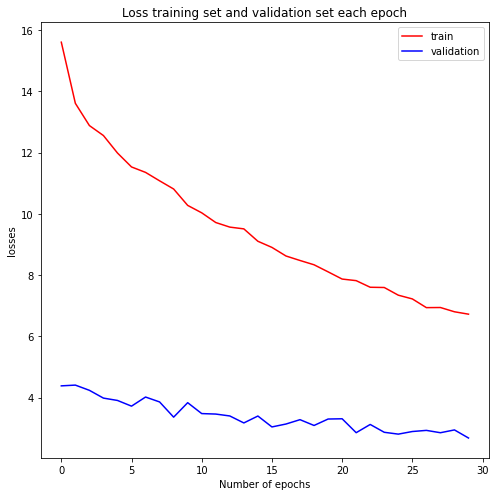

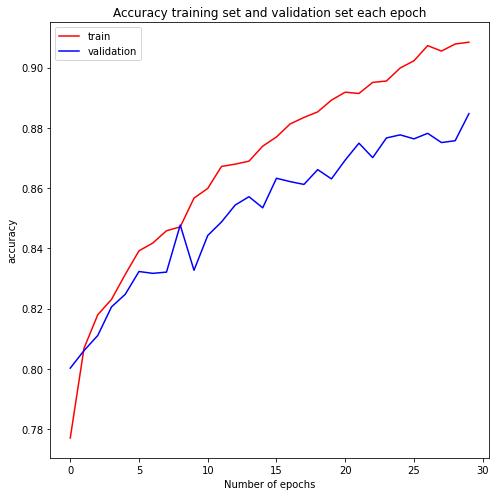

In [ ]:
siam_model = SiameseNet_Resnet18_Triple().to(device)
print(siam_model)
losses, accuracies = train_triplet(siam_model, train_dl, vali_dl, 30)
title = "Loss training set and validation set each epoch"
plot_curve_error(losses, title, loss=True)
title = "Accuracy training set and validation set each epoch"
plot_curve_error(accuracies, title, loss=False)



### Testing Function with ROC 

Load the net after training with triplet loss:

In [ ]:
net_empty = SiameseNet_Resnet18_Triple().to(device)
net_empty.load_state_dict(torch.load("siamese_net.pt"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
from sklearn import metrics

In [ ]:
def calculate_acc_roc_two(dataset_loader, net):
    n_correct = 0
    n_total = 0 
    postive_distance,negative_distance = [],[]
    with torch.no_grad():
       net.eval()
       for batch_idx,data in enumerate(dataset_loader):
          img0,class_img0, img1 ,class_img1, label  = data[0], data[1], data[2], data[3], data[4]
          img0,class_img0, img1 ,class_img1, label = img0.to(device), class_img0.to(device), img1.to(device), class_img1.to(device), label.to(device)
          if label ==1: #not same aritsts
            img_p = torch.zeros(img0.shape)
            img_p  = img_p.to(device)
            output_a, output_p, output_n = net(img0, img_p, img1)
            diff_n = F.pairwise_distance(output_a, output_n)
            negative_distance.append(diff_n.detach().cpu())
          else:   #same artists
            img_n = torch.zeros(img0.shape)
            img_n  = img_n.to(device)
            output_a, output_p, output_n = net(img0, img1, img_n)
            diff_p = F.pairwise_distance(output_a, output_p)
            postive_distance.append(diff_p.detach().cpu())
    print("sizes before, positive {0}, negative {1}".format(len(postive_distance),len(negative_distance)))
    diff = abs(len(postive_distance)-len(negative_distance))
    if len(postive_distance) > len(negative_distance):
      postive_distance = postive_distance[:-diff]
    else:
      negative_distance = negative_distance[:-diff]
    print("sizes after, positive {0}, negative {1}".format(len(postive_distance),len(negative_distance)))
    return postive_distance,negative_distance

In [ ]:
def final_roc(postive_distance,negative_distance):
    start_thres = 0
    thresholds = np.linspace(0,500,1000)
    tpr , fpr =[],[]
    for threshold in thresholds:
      tp = sum(postive_distance < threshold) / len(postive_distance)
      tpr.append(tp)
      fp = sum(negative_distance < threshold) / len(negative_distance)
      fpr.append(fp)
    plot_roc_curve(fpr, tpr)
    fpr_np = np.array(fpr)
    tpr_np = np.array(tpr)
    subtracted_array = np.subtract(tpr_np, fpr_np)
    best_index = np.argmax(subtracted_array)
    best_threshold = thresholds[best_index]
    print("auc: ", metrics.auc(fpr, tpr))
    print("best threshold : ", best_threshold)


In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
postive_distance,negative_distance = calculate_acc_roc_two(test_dl,net_empty)

sizes before, positive 2338, negative 2387
sizes after, positive 2338, negative 2338


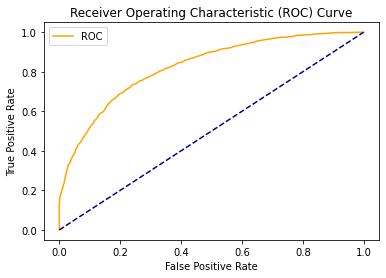

auc:  0.8252029181280601
best threshold :  120.62062062062063


In [ ]:
final_roc(postive_distance,negative_distance)

### How to use the network without labels

In [ ]:
def plot_result(image1,image2,npimg1,npimg2,title1,title2):
    fig_sub, ax = plt.subplots(1, 2)
    ax[0].imshow(npimg1) 
    ax[0].axis("off")
    ax[0].set_title(title1)
    ax[1].imshow(npimg2) 
    ax[1].axis("off")
    ax[1].set_title(title2)
    fig_sub.show()  
    #optimal threshold from Roc:
    best_threshold = 120.62062062062063
    img_z = torch.zeros(image1.shape)
    image1 =image1.to(device) ; image2=image2.to(device) ; image2 =image2.to(device) ;img_z  = img_z.to(device)
    image1 =image1.unsqueeze(0)
    image2 =image2.unsqueeze( 0)
    img_z = img_z.unsqueeze( 0)
    output_a, output_p, output_n = net_empty(image1, img_z, image2)
    diff_n = F.pairwise_distance(output_a, output_n)
    labels = {0:"Same artists",1:"Different artists"}

    #if the distance > threshold then different artists,otherwise same
    cond = int(diff_n>best_threshold)
    fig_sub.suptitle("Result:  "+labels[cond], fontsize=14)



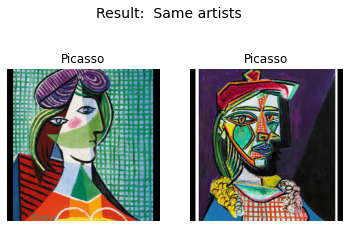

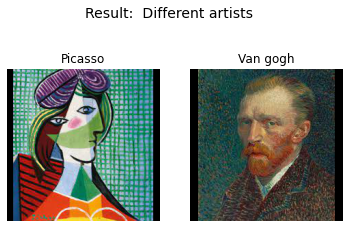

In [ ]:
def test_real():

  transform = transforms.Compose([
      transforms.CenterCrop(224),
      transforms.ToTensor() 
  ])
  net_empty.eval()

  image1 =  transform(Image.open("picasso.jpeg").convert('RGB'))
  image2 =  transform(Image.open("picasso2.jpeg").convert('RGB'))
  image3 = transform(Image.open("van_gogh.jpeg").convert('RGB'))
  npimg1=np.transpose(image1.numpy(), (1, 2, 0)) #from BRG to RGB
  npimg2=np.transpose(image2.numpy(), (1, 2, 0)) #from BRG to RGB
  npimg3=np.transpose(image3.numpy(), (1, 2, 0)) #from BRG to RGB
  plot_result(image1,image2,npimg1,npimg2,"Picasso","Picasso")
  plot_result(image1,image3,npimg1,npimg3,"Picasso","Van gogh")

  
test_real()